# Install Roboflow and Detectron2

In [1]:
!python -m pip install roboflow
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 8.5 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.1
    Uninstalling pyparsing-3.1.1:
      Successfully uninstalled pyparsing-3.1.1
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.1.78
    Uninstalling opencv-python-headless-4.8.1.78:
      Successfully uninsta

In [2]:
import logging
import torch
from collections import OrderedDict
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.utils.events import EventStorage
from detectron2.modeling import build_model
import detectron2.utils.comm as comm
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    LVISEvaluator,
    PascalVOCDetectionEvaluator,
    SemSegEvaluator,
    inference_on_dataset,
    print_csv_format,
)

from roboflow import Roboflow

from matplotlib import pyplot as plt
from PIL import Image

# Download dataset via Roboflow pip package and show a sample annotation

In [3]:

from roboflow import Roboflow
rf = Roboflow(api_key="FZJGVchXCxn1KwMdjSQK")
project = rf.workspace("alpaco5-f3woi").project("part-autolabeld")
dataset = project.version(5).download("coco")



loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to part-autolabeld-5 in coco:: 100%|██████████| 9447/9447 [00:03<00:00, 2945.11it/s]


In [5]:
register_coco_instances("car_train", {}, f"/content/part-autolabeld-5/train/_annotations.coco.json", f"/content/part-autolabeld-5/train/")
register_coco_instances("car_valid", {}, f"/content/part-autolabeld-5/valid/_annotations.coco.json", f"/content/part-autolabeld-5/valid/")
register_coco_instances("car_test", {}, f"/content/part-autolabeld-5/test/_annotations.coco.json", f"/content/part-autolabeld-5/test/")

[12/08 18:32:47 d2.data.datasets.coco]: Loading /content/part-autolabeld-5/train/_annotations.coco.json takes 3.51 seconds.
WARNING [12/08 18:32:47 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/08 18:32:47 d2.data.datasets.coco]: Loaded 6603 images in COCO format from /content/part-autolabeld-5/train/_annotations.coco.json


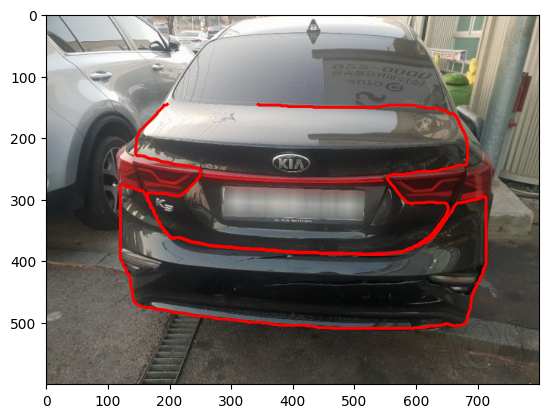

In [6]:
dataset_train = DatasetCatalog.get("car_train")
fig, ax = plt.subplots()
dataset_dict = random.choice(dataset_train)
im = Image.open(dataset_dict['file_name'])
ax.imshow(im)
for ann in dataset_dict['annotations']:
    for poly in ann['segmentation']:
        x = poly[0::2]
        y = poly[1::2]
        ax.plot(x,y, linewidth=2, color='red')

# Configure Detectron2 for fine tuning from COCO, Define training loop helper functions (from detectron2 repo), Run custom training loop

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("car_train",)#Train dataset registered in a previous cell
cfg.DATASETS.TEST = ("car_test",)#Test dataset registered in a previous cell
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 2000 #We found that with a patience of 500, training will early stop before 10,000 iterations
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14
cfg.TEST.EVAL_PERIOD = 100 # Increase this number if you want to monitor validation performance during training

PATIENCE = 100 #Early stopping will occur after N iterations of no imporovement in total_loss

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [8]:
def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type in ["sem_seg", "coco_panoptic_seg"]:
        evaluator_list.append(
            SemSegEvaluator(
                dataset_name,
                distributed=True,
                output_dir=output_folder,
            )
        )
    if evaluator_type in ["coco", "coco_panoptic_seg"]:
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if evaluator_type == "coco_panoptic_seg":
        evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
    if evaluator_type == "cityscapes_instance":
        return CityscapesInstanceEvaluator(dataset_name)
    if evaluator_type == "cityscapes_sem_seg":
        return CityscapesSemSegEvaluator(dataset_name)
    if evaluator_type == "pascal_voc":
        return PascalVOCDetectionEvaluator(dataset_name)
    if evaluator_type == "lvis":
        return LVISEvaluator(dataset_name, cfg, True, output_folder)
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)

def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


logger = logging.getLogger("detectron2")
resume=False
model = build_model(cfg)
optimizer = build_optimizer(cfg, model)
scheduler = build_lr_scheduler(cfg, optimizer)

BEST_LOSS = np.inf

checkpointer = DetectionCheckpointer(
    model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
)
start_iter = (
    checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
)
prev_iter = start_iter
max_iter = cfg.SOLVER.MAX_ITER

periodic_checkpointer = PeriodicCheckpointer(
    checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
)

writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

# compared to "train_net.py", we do not support accurate timing and
# precise BN here, because they are not trivial to implement in a small training loop
data_loader = build_detection_train_loader(cfg)
logger.info("Starting training from iteration {}".format(start_iter))
patience_counter = 0
with EventStorage(start_iter) as storage:
    for data, iteration in zip(data_loader, range(start_iter, max_iter)):
        storage.iter = iteration

        loss_dict = model(data)
        losses = sum(loss_dict.values())
        assert torch.isfinite(losses).all(), loss_dict

        loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        if comm.is_main_process():
            storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
        scheduler.step()

        if (
            cfg.TEST.EVAL_PERIOD > 0
            and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
            and iteration != max_iter - 1
        ):
            do_test(cfg, model)
            # Compared to "train_net.py", the test results are not dumped to EventStorage
            comm.synchronize()

        if iteration - start_iter > 5 and (
            (iteration + 1) % 20 == 0 or iteration == max_iter - 1
        ):
            for writer in writers:
                writer.write()
        periodic_checkpointer.step(iteration)

        if iteration > prev_iter:
            prev_iter = iteration
            if losses_reduced < BEST_LOSS:
                BEST_LOSS = losses_reduced
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter % 100 == 0:
                    print(f"Loss has not improved for {patience_counter} iterations")
                if patience_counter >= PATIENCE:
                    print(f"EARLY STOPPING")
                    break

do_test(cfg, model)

[12/08 18:34:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:01, 108MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[12/08 18:34:20 d2.data.datasets.coco]: Loading /content/part-autolabeld-5/train/_annotations.coco.json takes 2.26 seconds.
WARNING [12/08 18:34:20 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/08 18:34:20 d2.data.datasets.coco]: Loaded 6603 images in COCO format from /content/part-autolabeld-5/train/_annotations.coco.json
[12/08 18:34:20 d2.data.build]: Removed 1 images with no usable annotations. 6602 images left.
[12/08 18:34:20 d2.data.build]: Distribution of instances among all 15 categories:
|  category  | #instances   |  category   | #instances   |  category   | #instances   |
|:----------:|:-------------|:-----------:|:-------------|:-----------:|:-------------|
|  car-part  | 0            |   Bonnet    | 980          | Frontbumper | 2364         |
| Frontdoor  | 1986         | Frontfender | 1771         | Headlights  | 1123         |
| Rearbumper | 2338         |  Reardoor   | 1900         | Rearfender  | 

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)


[12/08 18:35:02 d2.utils.events]:  iter: 19  total_loss: 3.617  loss_cls: 2.561  loss_box_reg: 0.2049  loss_mask: 0.6927  loss_rpn_cls: 0.1048  loss_rpn_loc: 0.03887     lr: 4.9952e-05  max_mem: 11266M
[12/08 18:35:45 d2.utils.events]:  eta: 1:10:27  iter: 39  total_loss: 2.133  loss_cls: 1.082  loss_box_reg: 0.2222  loss_mask: 0.6885  loss_rpn_cls: 0.07446  loss_rpn_loc: 0.03414     lr: 9.9902e-05  max_mem: 11719M
[12/08 18:36:28 d2.utils.events]:  eta: 1:09:25  iter: 59  total_loss: 1.464  loss_cls: 0.4127  loss_box_reg: 0.2395  loss_mask: 0.6788  loss_rpn_cls: 0.05656  loss_rpn_loc: 0.03326     lr: 0.00014985  max_mem: 11719M
[12/08 18:37:12 d2.utils.events]:  eta: 1:10:13  iter: 79  total_loss: 1.44  loss_cls: 0.4214  loss_box_reg: 0.2849  loss_mask: 0.6689  loss_rpn_cls: 0.03996  loss_rpn_loc: 0.02763     lr: 0.0001998  max_mem: 11719M
WARNING [12/08 18:37:56 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/08 18

OrderedDict([('bbox',
              {'AP': 6.369617471838169,
               'AP50': 17.98532204415978,
               'AP75': 2.531842291131633,
               'APs': nan,
               'APm': 0.05775577557755777,
               'APl': 6.491545658142915,
               'AP-car-part': nan,
               'AP-Bonnet': 0.014144271570014143,
               'AP-Frontbumper': 21.404304817097835,
               'AP-Frontdoor': 3.6443007499603968,
               'AP-Frontfender': 4.313780433645181,
               'AP-Headlights': 3.0157011927172928,
               'AP-Rearbumper': 10.24252372721461,
               'AP-Reardoor': 11.851275231402852,
               'AP-Rearfender': 2.3511963668542974,
               'AP-Rearlamp': 0.0,
               'AP-Rockerpanel': 6.436153698271964,
               'AP-Sidemirror': 4.125412541254126,
               'AP-Trunklid': 6.502568613773753,
               'AP-Wheel': 15.273282961972058,
               'AP-Windshield': 0.0}),
             ('segm',
  